In [13]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/custom.css">

# Hackathon!

It is time to put your accumulated time series skills to work. You can select one of the offered datasets or work with your own. There will be a range of questions based on the materials we have covered, but you are encouraged to do your own data exploration and answer your own questions!

Good luck!

In [14]:
import datetime as dt

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#from fbprophet import Prophet

%matplotlib inline
plt.rcParams["font.size"] = 14
plt.rcParams['figure.figsize'] = (20.0, 10.0)

#from sklego.preprocessing import RepeatingBasisFunction

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures

# The Data
![footer_logo](images/cheese.jpeg)

### Dataset 1: Cheese Production in the Netherlands

The processing of raw cow's milk into cheese products by dairy factories in the Netherlands. The raw material for these products is the volume of cow's milk collected from dairy farmers in the Netherlands as well as imported milk. This dataset contains only cheeses made from cow milk only. Data comes from [CBS](https://opendata.cbs.nl/statline/#/CBS/en/dataset/7425eng/table?dl=31ECC).

In [15]:
cheese = pd.read_csv('data/cheese_production.csv')
cheese.head()

,date,cheese_production
0,1995 January,58071
1,1995 February,53419
2,1995 March,59799
3,1995 April,57396
4,1995 May,59326


![footer_logo](images/car.jpeg)

### Dataset 2: Road Accidents in United Kingdom

The UK government [collects](https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles) and publishes detailed information about traffic accidents across the country. This information includes, but is not limited to, geographical locations, weather conditions, type of vehicles and number of casualties. The current dataset focuses on the aggregate number of traffic accidents. 

In [16]:
accidents = pd.read_csv('data/accidents.csv')
accidents.head()

,Date,cases
0,2005-01-31,525.096774
1,2005-02-28,518.607143
2,2005-03-31,483.129032
3,2005-04-30,522.033333
4,2005-05-31,549.419355


### Dataset 3: Your Own Dataset

If you have another interesting time series dataset to work with, feel free to focus on it instead, but try to answer the questions in the assignments below.

In [17]:
#load your data here


# The Assignment

You are strongly encouraged to explore your chosen dataset and think of some questions you might want to answer. Write down some ideas here! 


However, we will also provide you with some questions to guide the exploration and analysis process. 

## Questions
Follow the below questions to analyze the chosen time series, but do not feel too restricted by them. It is also a good idea to think of your own questions and answer them along the way.

*Note:* the $y$ value (cheese production, number of accidents etc) is further referred to as "*the value*"

### Preliminary 

#### 1. Is the date set as the index? If not, make sure it is set! 

In [18]:
accidents = pd.read_csv('data/accidents.csv',  parse_dates=['Date'], index_col='Date')
accidents

,cases
Date,
2005-01-31,525.096774
2005-02-28,518.607143
2005-03-31,483.129032
2005-04-30,522.033333
2005-05-31,549.419355
...,...
2017-08-31,332.290323
2017-09-30,369.700000
2017-10-31,361.096774


#### 2. What range of dates does the dataset cover? How frequent are timestamps?

In [19]:
accidents.index[0]

Timestamp('2005-01-31 00:00:00')

#### 3. When is the highest / lowest value of $y$ observed and what is it?

In [20]:
accidents.cases.min()

accidents.cases.max()

624.9

#### 4. Plot the data. Do you see any yearly, monthly or any other cycles? Is there a trend?

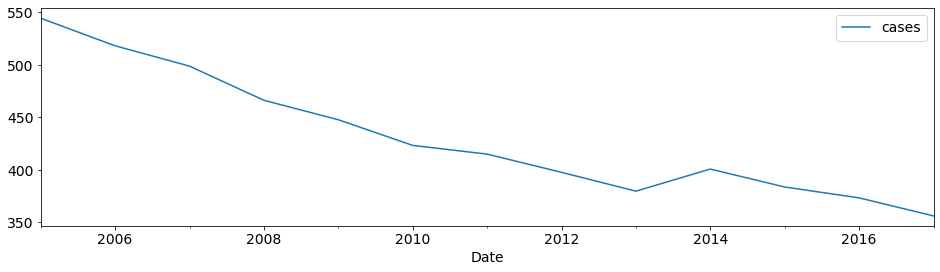

In [21]:
acc = accidents.resample('Y').mean()
acc

acc.plot(figsize=(16,4));

### Data Analysis

#### 1. Use `.resample()` method to find quarterly  averages. In which quarter are the highest values observed?

Timestamp('2005-12-31 00:00:00', freq='Q-DEC')

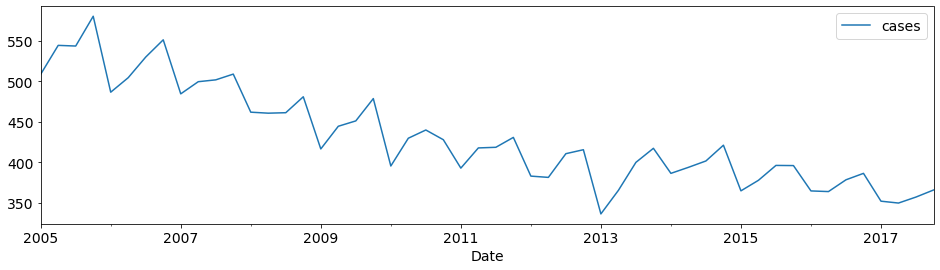

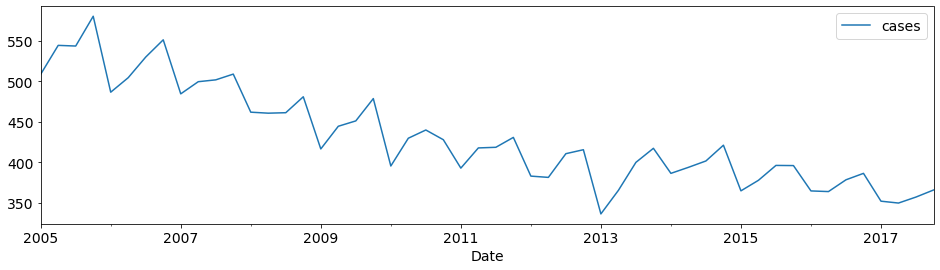

In [22]:
acc = accidents.resample('Q').mean()
acc
acc.plot(figsize=(16,4));

(
    acc
    .assign(quarter = lambda df: df.index.quarter)
    .head()
)
acc.plot(figsize=(16,4));
maxValue = acc.max()['cases']
maxValue
maxindex = acc['cases'].idxmax()
maxindex

#### 2. In which month on average do the values change the most compared to the previous month?

In [23]:
acc = accidents.resample('M').mean()
acc

,cases
Date,
2005-01-31,525.096774
2005-02-28,518.607143
2005-03-31,483.129032
2005-04-30,522.033333
2005-05-31,549.419355
...,...
2017-08-31,332.290323
2017-09-30,369.700000
2017-10-31,361.096774


#### 3. Plot two centered rolling means with two different windows. 

<AxesSubplot:xlabel='month', ylabel='change'>

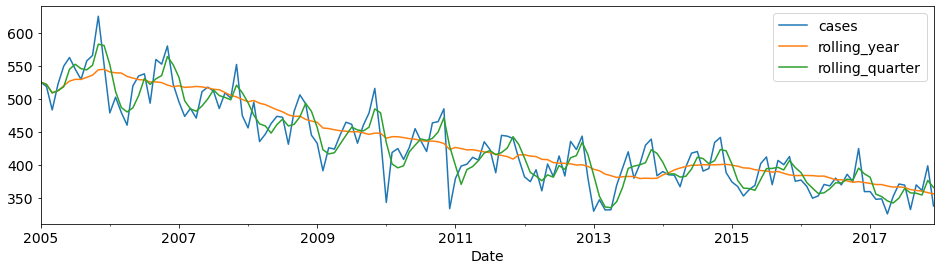

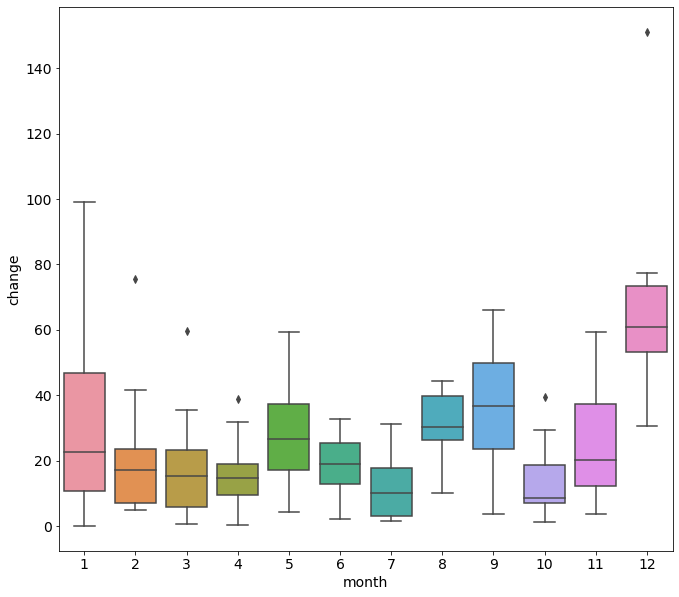

In [24]:
(
    acc
    .assign(rolling_year=lambda df: df['cases'].rolling('365D').mean())
    .assign(rolling_quarter=lambda df: df['cases'].rolling('90D').mean())
    .plot(figsize=(16, 4))
);

acc = (
    acc
    .assign(cases_last_month = lambda df: df.cases.shift(1))
    .assign(cases_increase = lambda df: df.cases - df.cases_last_month)
    .assign(month = lambda df: df.index.month)
    .assign(change = lambda df: df['cases_increase'].abs())

)
import seaborn as sns
acc.head(500)
fig, axes = plt.subplots(1, 1, figsize=(11, 10), sharex=True)
sns.boxplot(x = 'month',y='change',data=acc)



### Modeling
#### 1. Fit and plot a linear model. Does it adequately represent the trend?

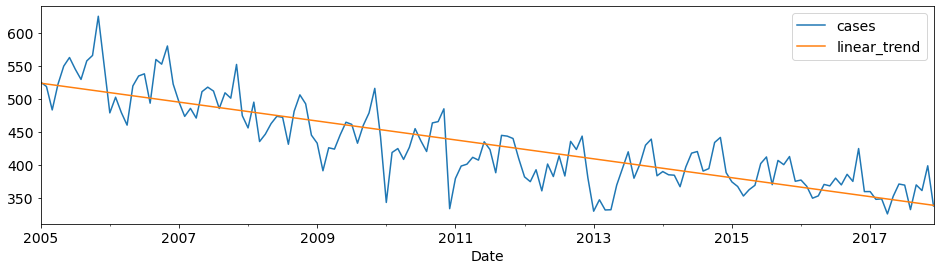

In [25]:

acc['time'] = np.arange(len(acc.index))

X = acc[['time']]
y = acc['cases'].values
lm = LinearRegression()
lm.fit(X, y)

acc['linear_trend'] = lm.predict(X)
acc[['cases','linear_trend']].plot(figsize=(16,4));

#### 2. Are there any noticeable break points? If so, add respective dummy(s) & interactions to the linear model.

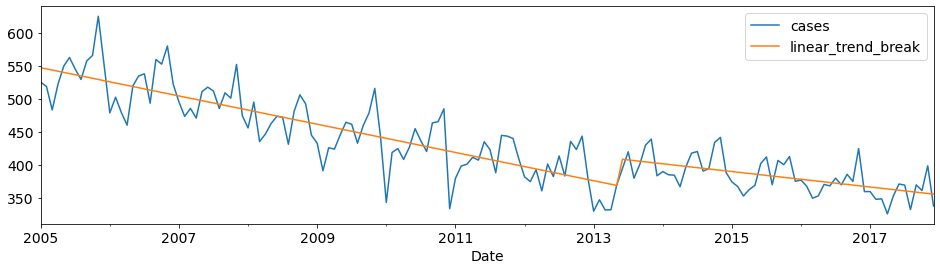

In [29]:

X_break = (
    acc
    .assign(after201306 = [1 if el>pd.Timestamp('2013-6') else 0 for el in acc.index],
            interaction = lambda df: df['time']*df['after201306'])
    [['time', 'after201306','interaction']]
)

lm_break = LinearRegression().fit(X_break, y)

acc['linear_trend_break'] = lm_break.predict(X_break)
acc[['cases','linear_trend_break']].plot(figsize=(16,4));

#### 3. Add seasonal dummies to the model. How frequent should they be to capture seasonality well?

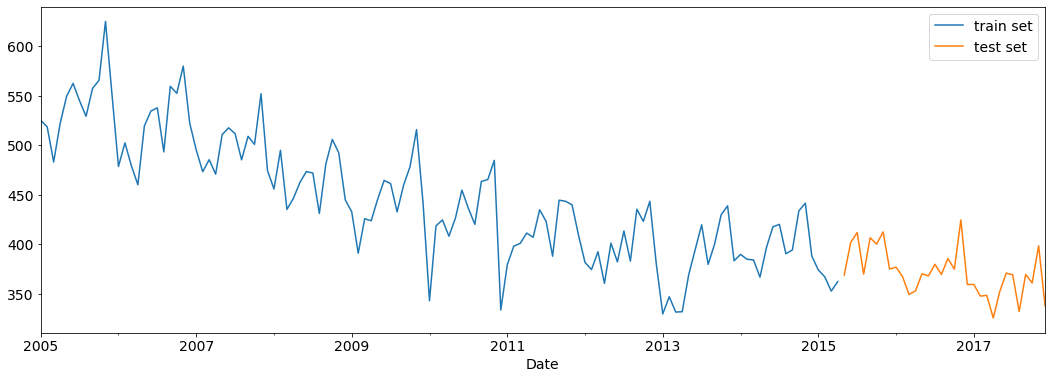

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

#identifying months and preprocessing them
acc['month']=acc.index.month

#train-test split
acc_train = acc.loc[:'2015-4'].copy()
acc_test = acc.loc['2015-5':].copy()

#train-test split illustrated
fig, ax = plt.subplots(figsize=(18,6))
acc_train[['cases']].plot(ax=ax)
acc_test[['cases']].plot(ax=ax)
plt.legend(["train set","test set"]);

In [31]:
#adding month indicators
X_monthly=acc_train[['time','month']]
y_train = acc_train['cases'].values
# this is tradition to drop one of the columns in onehotencoder, arbitrarily the first one
feature_transformer = ColumnTransformer(
      [('categorical', OneHotEncoder(drop='first'), ['month'])],
    remainder='passthrough'
)

In [33]:

#training the model
model_monthly = Pipeline([
    ('preprocess', feature_transformer),
    ('model', LinearRegression())
])

lm_monthly = model_monthly.fit(X_monthly, y_train)
print(f"R^2 is {round(lm_monthly.score(X_monthly, y_train),3)}")

acc['y_pred_monthly'] = lm_monthly.predict(acc[['time','month']])

R^2 is 0.872


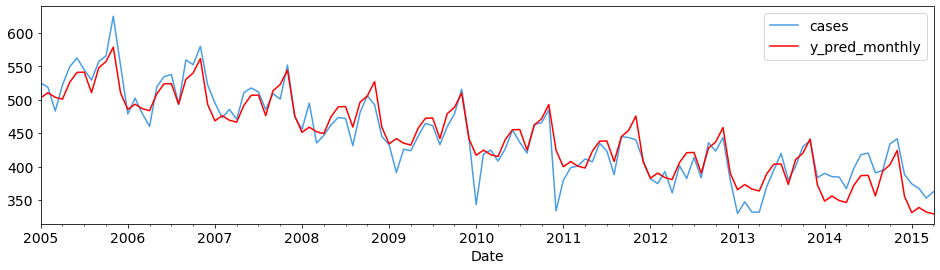

In [34]:
acc[['cases','y_pred_monthly']].loc[:'2015-4'].plot(figsize=(16,4), color=['#499DE6','red']);

In [37]:

average_season_effect = np.dot(lm_monthly['model'].coef_[:-1], [1/12]*11)

simple_ets = (
    acc
    [['cases','y_pred_monthly', 'time']]
    .loc[:'2015-4']
    .rename(columns={"cases": "y_real", "y_pred_monthly": "y_hat"})
    .assign(residuals = lambda df: df['y_real']-df['y_hat'],
            trend = lambda df: lm_monthly['model'].intercept_+lm_monthly['model'].coef_[-1]*df['time']+average_season_effect,
            seasonal = lambda df: df['y_hat']-df['trend']
           )
)

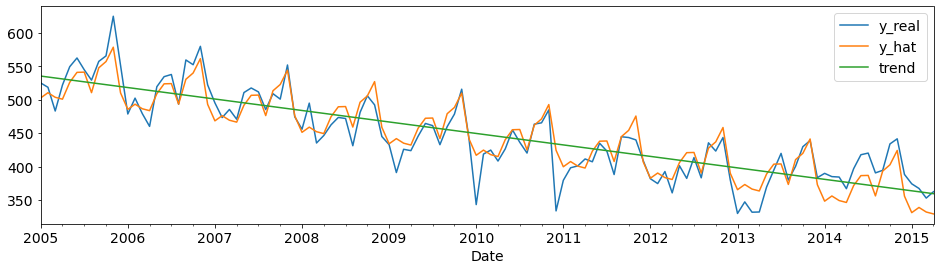

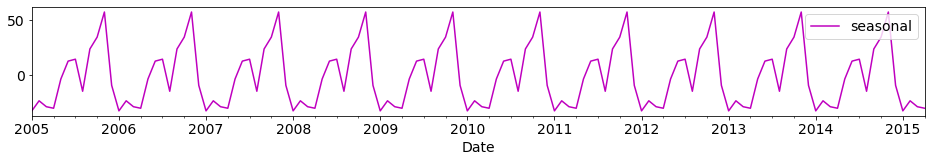

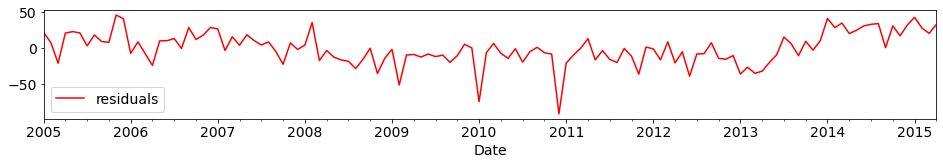

In [38]:

simple_ets[['y_real','y_hat','trend']].plot(figsize=(16,4))
simple_ets[['seasonal']].plot(figsize=(16,2), c='m')
simple_ets[['residuals']].plot(figsize=(16,2), c='r');

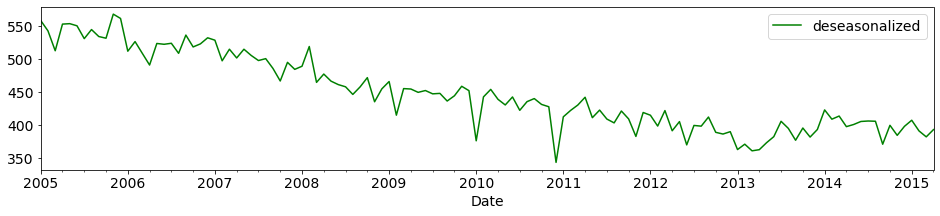

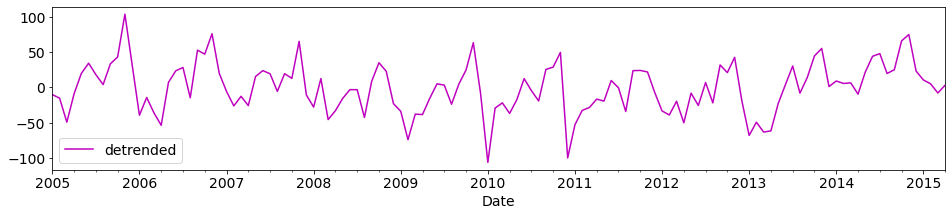

In [39]:

simple_ets = (simple_ets
              .assign(deseasonalized = lambda df: df['y_real']-df['seasonal'],
                      detrended = lambda df: df['y_real']-df['trend']))

simple_ets[['deseasonalized']].plot(figsize=(16,3), c='g', label="deseasonalized time series")
simple_ets[['detrended']].plot(figsize=(16,3), c='m', label="detrended time series");

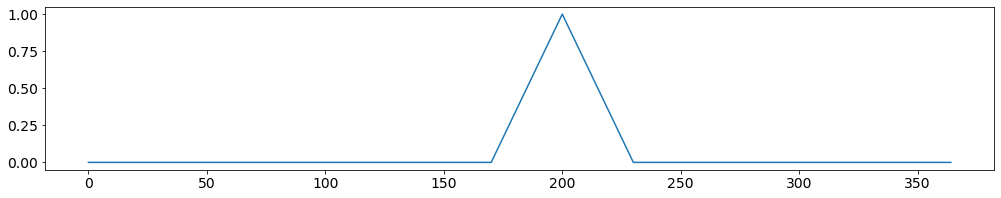

In [40]:

def gsf_feature_maker(day, center_day, n=30):
    if day - center_day >= 334:
        day = day - 365 #ensures continuity for December-January
    return np.fmax(-np.abs(day - center_day)/n + 1, 0)

base = [gsf_feature_maker(el, 200) for el in np.arange(365)]
plt.figure(figsize = (17,3))
plt.plot(base);

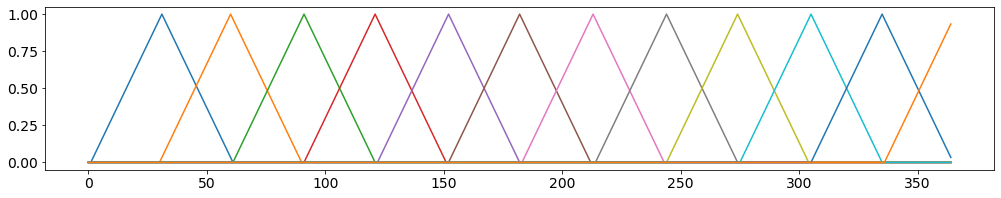

In [41]:
months = pd.date_range('2008-01-01', periods = 12, freq = 'M')

fig, ax = plt.subplots(figsize=(17,3))
for month in months:
    ax.plot([gsf_feature_maker(el, month.dayofyear) for el in np.arange(365)])

In [43]:

acc_gsf=acc[['cases','time']].copy()
acc_gsf['month']=acc_gsf.index.month
acc_gsf['dayofyear']=acc_gsf.index.dayofyear

#determining month starting days as day of the year numbers
month_start_days=[]
for i in range(1,13):
    month_start_days.append(acc_gsf.loc[lambda df: df.month==i].iloc[0]['dayofyear'])

month_start_days

[31.0,
 59.0,
 90.0,
 120.0,
 151.0,
 181.0,
 212.0,
 243.0,
 273.0,
 304.0,
 334.0,
 365.0]

In [44]:

#Adding 12 GSF features to the dataset
for i in range(12):
    feature_name="f"+str(i)
    peak = month_start_days[i]
    acc_gsf[feature_name] = [gsf_feature_maker(date.dayofyear, peak) for date in acc_gsf.index]

In [45]:
acc_gsf.head()

,cases,time,month,dayofyear,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
Date,,,,,,,,,,,,,,,,
2005-01-31,525.096774,0,1,31,1.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-02-28,518.607143,1,2,59,0.066667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-03-31,483.129032,2,3,90,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-04-30,522.033333,3,4,120,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-31,549.419355,4,5,151,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


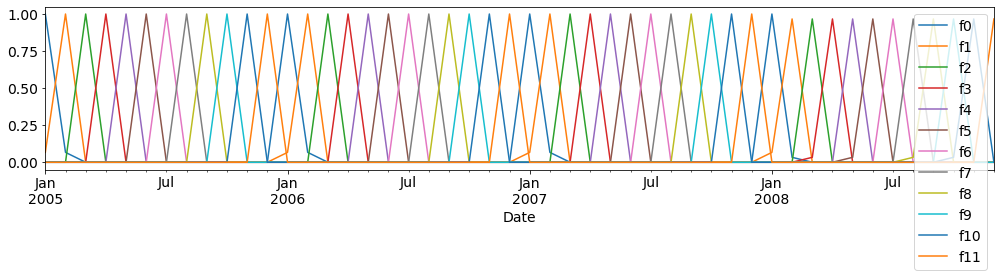

In [46]:

#inspecting the new features visually
fig, ax = plt.subplots(figsize=(17,3))
for i in range(12):
    feature_name="f"+str(i)
    acc_gsf[[feature_name]].loc[:'2008'].plot(ax=ax)

In [47]:
X_gsf = np.c_[acc_gsf[['time']], acc_gsf.iloc[:,4:]]
X_gsf_train = np.c_[acc_gsf[['time']].loc[:'2015-4'], acc_gsf.iloc[:,4:].loc[:'2015-4']]
y_train = acc_gsf['cases'].loc[:'2015-4']

lm_gsf = LinearRegression().fit(X_gsf_train, y_train)
print(f"R^2 is {round(lm_gsf.score(X_gsf_train, y_train),3)}")

acc_gsf['gsf_pred'] = lm_gsf.predict(X_gsf)

R^2 is 0.875


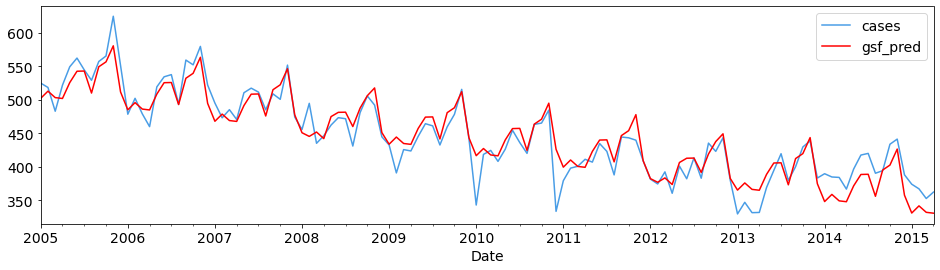

In [48]:
acc_gsf[['cases','gsf_pred']].loc[:'2015-4'].plot(figsize=(16,4), color=['#499DE6','red']);

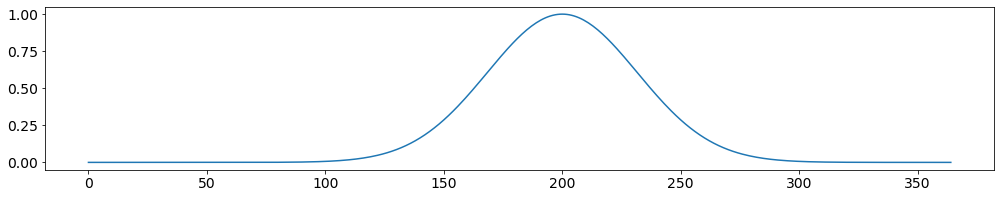

In [49]:
def rbf_feature_values(day, center_day, year_days=365, alpha = 0.005):
    return np.exp(-((day - center_day)**2)/2*alpha)

base = [rbf_feature_values(el, 200, alpha = 0.001) for el in np.arange(365)]
plt.figure(figsize = (17,3))
plt.plot(base);

In [51]:
from regressors import stats

print("\n=========== SUMMARY ===========")
xlabels = ["time"] + list(acc_gsf.iloc[:,4:-1].columns)
stats.summary(lm_gsf, X_gsf_train, y_train, xlabels)


=========== SUMMARY ===========
Residuals:
     Min       1Q  Median      3Q     Max
-49.3757 -12.9005  1.0405 10.7435 92.6174


Coefficients:
              Estimate  Std. Error  t value   p value
_intercept  249.985712   49.952267   5.0045  0.000002
time         -1.426717    0.028211 -50.5728  0.000000
f0          235.815955   46.934952   5.0243  0.000002
f1          248.790680   48.027929   5.1801  0.000001
f2          256.332388   52.538044   4.8790  0.000003
f3          256.464143   53.088583   4.8309  0.000004
f4          281.568937   52.813832   5.3313  0.000000
f5          299.975811   53.417969   5.6156  0.000000
f6          301.702325   53.415955   5.6482  0.000000
f7          270.266619   52.815763   5.1172  0.000001
f8          310.895699   53.421180   5.8197  0.000000
f9          319.688148   52.819026   6.0525  0.000000
f10         345.032644   53.425322   6.4582  0.000000
f11         277.638332   53.425169   5.1968  0.000001
---
R-squared:  0.87538,    Adjusted R-squared

In [ ]:
# outliers

acc_gsf['cases'].iloc[0]

In [53]:

#detecting datapoints deviating more than 20% from the model
outliers=[]

for i in range(len(acc_gsf)):

    if np.abs(acc_gsf['cases'].iloc[i]-acc_gsf['gsf_pred'].iloc[i])/acc_gsf['gsf_pred'].iloc[i]>0.15:
        outliers.append(acc_gsf['cases'].iloc[i])
    else:
        outliers.append(np.nan)

acc_gsf['outliers']=outliers

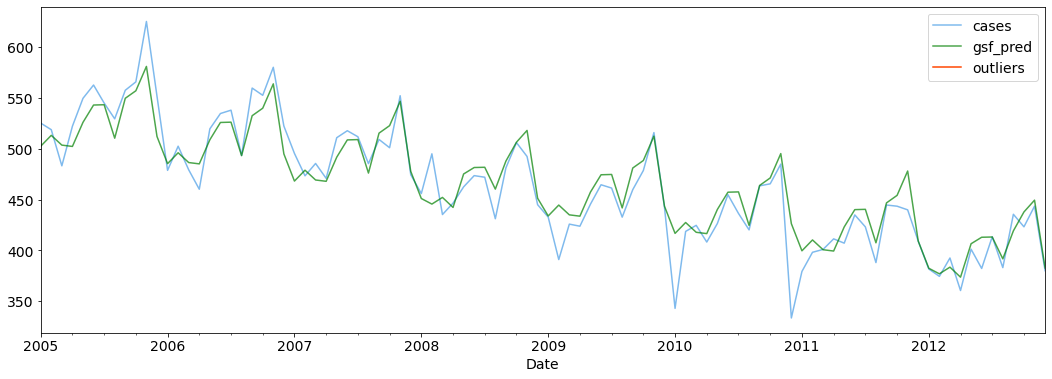

In [54]:


#illustrating outliers
fig, ax = plt.subplots(figsize=(18,6))
acc_gsf[['cases','gsf_pred']].loc[:'2012'].plot(color=['#499DE6','green'], ax=ax, alpha=0.7)
acc_gsf[['outliers']].loc[:'2012'].plot(color='orangered', ax=ax);

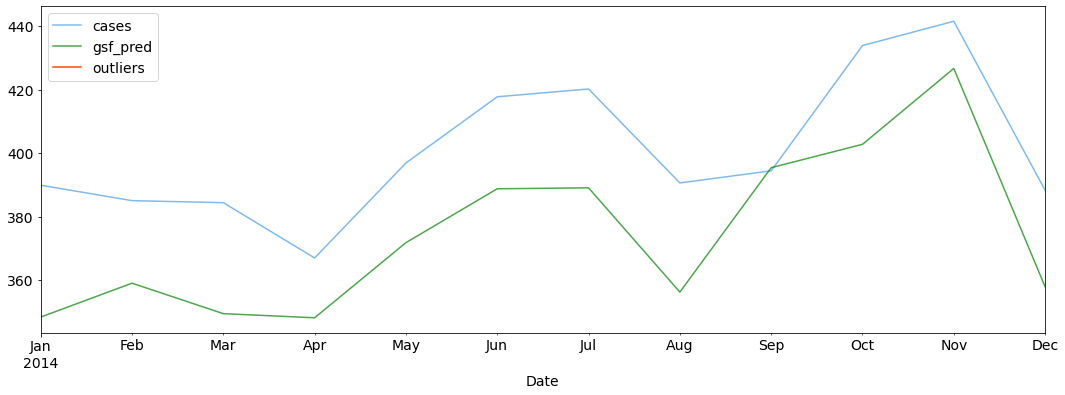

In [55]:
#2014 zoom in: droughts and wildfires
fig, ax = plt.subplots(figsize=(18,6))
acc_gsf[['cases','gsf_pred']].loc['2014'].plot(color=['#499DE6','green'], ax=ax, alpha=0.7)
acc_gsf[['outliers']].loc['2014'].plot(color='orangered', ax=ax);